Modelling seal population sizes with Pyro
==========================================

> Pipeline to model detection error for CNN output and estimate seal haul out patterns and population sizes using environmental covariates. The model works accross two scales: patch (spatial scale for seal habitat use); and subpatch (spatial scale for seal haulout behavior). Besides being biologically inspired, some of the covariate data are extract from course resolution sensors (e.g. MODIS), thus separating between patch and subpatch scale prevents pseudoreplication at the subpatch level. Pyro is a probabilistic programming language developed by Uber using PyTorch as its backend. 


Setup
-------------------------

> Import a few packages, set random seed for reproducibility and enable output validation. 

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
warnings.simplefilter('ignore')

sns.set_context('notebook')

Reading training data
------------------------


### Covariate list

#### Patch (MODIS, 250m):

1. Chlorophyl concentration
2. Distance to continental shelf break
3. Julian Day
4. Time of the day
5. Sea ice concentration

#### Subpatch (WV03, 0.3m):

1. Floe size
2. Sea ice concentration

#### Observed variables (Subpatch):

1. Observed seals on ice (*N_obs*)
2. True number of seals on ice (*N_ice*)

#### Additional covariates?
* Past season covariate values
* Species occurrence (krill, seabirds, whales...)


In [29]:
# read patch level data
data_patch = gpd.read_file('covariates/covariates_patch.dbf')

# read subpatch level data
data_subp = gpd.read_file('covariates/covariates_subp.dbf')

# reformat data
floe = [np.median(data_subp.loc[data_subp.patch_id == idx]['floe_size']) for idx in range(len(data_patch))]
N_ice = [np.sum(data_subp.loc[data_subp.patch_id == idx]['n_ice']) for idx in range(len(data_patch))]
cover = data_patch.sea_ice_co.values
n_patches = len(floe)

    

Model definition
-----

> Model definition includes model hierarchy and distribution of choice for each parameter. 

### Model equations

##### Deterministic:
$$ \lambda_{total[i]} = Softplus(a_{\lambda total} * X_{patch[i]} + b_{\lambda total})$$

$$ \lambda_{fp[i, j]} = Softplus(a_{\lambda fp} * X_{sub[i, j]} + b_{\lambda fp})$$

$$ \alpha_{haul patch[i]} = Softplus(a_{\alpha haul patch} * X_{patch[i]} + b_{\alpha haul patch})$$

$$ \beta_{haul patch[i]} = S='oftplus(a_{\beta haul patch} * X_{patch[i]} + b_{\beta haul patch})$$

$$ (\rho_{sub [i, 0]} ... \rho_{sub [i, j]}) = \dfrac{Softplus(a_{\rho sub} * (X_{sub[i, 0]} ... X_{sub[i, j]}))}{|Softplus(a_{\rho sub} * (X_{sub[i, 0]} ... X_{sub[i, j]}))|}$$



##### Probabilistic:

$$ N_{total[i]} \sim Poisson(\lambda_{total[i]})$$

$$ \phi_{haul patch[i]} \sim Beta(\alpha_{haul patch[i]}, \beta_{haul patch[i]}) $$

$$ N_{ice patch[i]} \sim Binomial(N_{total[i]}, \phi_{haul_patch})$$

$$ (\phi_{haul sub[i, 0]} ... \phi_{haul sub[i, j]}) \sim Dirichlet(\rho_{sub [i, 0]} ... \rho_{sub [i, j]}) $$

$$ (N_{ice[i, 0]} ...  N_{ice[i, j]}) \sim Multinomial(N_{haul patch[i]}, \phi_{haul sub[i, 0]} ... \phi_{haul sub[i, j]})$$

$$ FalsePositives_{[i, j]} \sim Poisson(\lambda_{fp[i, j]}) $$

$$ N_{det[i, j]} \sim Binomial \left(N_{ice[i, j]} + \dfrac{FalsePositives_{[i, j]}}{\phi_{det[i, j]}},  \phi_{det[i, j]} \right) $$  



Testing simpler model formulations
---

### model v1 definition

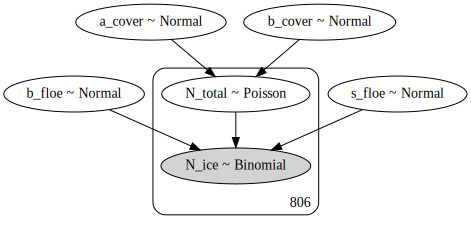

In [38]:
from theano.tensor.nnet.nnet import sigmoid, softplus
from pymc3 import Normal, Poisson, Binomial, sample, Model, model_to_graphviz, Metropolis
                           

with Model() as seals_model_v1:
    
    # priors for model parameters
    b_floe = Normal('b_floe', 0, 100)
    a_floe = Normal('s_floe', 0, 100)
    
    b_cover = Normal('b_cover', 0, 100)
    a_cover = Normal('a_cover', 0, 100)
    
    # deterministic functions
    lambda_total = softplus(a_cover * cover + b_cover)
    phi_haul = sigmoid(a_floe * floe + b_floe)
    
    # total number of seals
    N_total = Poisson('N_total', mu=lambda_total, shape=n_patches)
    
    # likelihood function
    N_ice_pred = Binomial('N_ice', n=N_total, p=phi_haul, observed=N_ice)
    
model_to_graphviz(seals_model_v1)

Results
----

In [40]:
from arviz import from_pymc3, plot_trace, rhat

# run model
with seals_model_v1:
    v1_trace = sample(draws=500, tune=5000000, n_init=200000, step=Metropolis(), start={'b_floe': 0, 's_floe': 0}, cores=6)

    
# inspect output
print(rhat(v1_trace))                                                          
v1_output = from_pymc3(v1_trace)

plot_trace(v1_output.posterior, var_names=['a_cover', 'b_cover'])

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [N_total]
>Metropolis: [a_cover]
>Metropolis: [b_cover]
>Metropolis: [s_floe]
>Metropolis: [b_floe]


OSError: [Errno 12] Cannot allocate memory

Train model
----

> We use an Adam optimizer to train our model for a given number of steps. We define a function to inspect optimization.

### *TODO :*
* Add support for training on mini-batches
* Check why values for **N_obs** fall outside of support sometimes
* Check why model is sensible to starting values

In [72]:
@poutine.broadcast
def model_fun1(data):
    # softplus transform as a link function
    softplus = torch.nn.Softplus()

    # extract patch and subpatch data
    patch_cols = [idx for idx, ele in enumerate(data.columns) if 'patch' in ele]
    subp_cols = [idx for idx, ele in enumerate(data.columns) if 'subp' in ele]
    cov_patch = data.iloc[:, patch_cols]
    cov_subp = data.iloc[:, subp_cols]

    # unroll covariate data to Tensors
    gt_N_ice = torch.Tensor([ele.cpu().numpy() for ele in data.true])
    gt_N_obs = torch.Tensor([ele.cpu().numpy() for ele in data.obs])
    cov_p = torch.randn([N_rows, 1, N_covs_patch])
    cov_s = torch.randn([N_rows, N_cols, N_covs_subp])
    for i in range(N_covs_patch):
        cov_p[:, :, i] = torch.Tensor([ele.cpu().numpy() for ele in cov_patch.iloc[:, i]])
    for i in range(N_covs_subp):
        cov_s[:, :, i] = torch.Tensor([ele.cpu().numpy() for ele in cov_subp.iloc[:, i]])

    
    # parameter names -- patch
    patch_par_names = []
    for par in ['a_', 'b_']:
        patch_par_names.extend([
            par + ele for ele in ['lambda_total', 'alpha_haul_prob_patch', 'beta_haul_prob_patch']
        ])

    # parameter names -- subpatch
    subp_par_names = []
    for par in ['a_', 'b_']:
        subp_par_names.extend([
            par + ele for ele in [
                'lambda_false_pos', 'alpha_haul_prob_subp', 'beta_haul_prob_subp', 'alpha_det',
                'beta_det'
            ]
        ])
    
    # parameter starting values
    alphas_patch = pyro.param('alphas_patch', torch.Tensor([1] * len(patch_par_names)), constraint=constraints.positive)
    betas_patch = pyro.param('betas_patch', torch.Tensor([1] * len(patch_par_names)), constraint=constraints.positive)
    alphas_subp = pyro.param('alphas_subp', torch.Tensor([1] * len(subp_par_names)), constraint=constraints.positive)
    betas_subp = pyro.param('betas_subp', torch.Tensor([1] * len(subp_par_names)), constraint=constraints.positive)

    patch_params = {
        ele: pyro.sample(
            ele,
            dist.Gamma(alphas_patch[idx], betas_patch[idx]).expand([N_covs_patch]).independent(1))
        for idx, ele in enumerate(patch_par_names)
    }

    
    subp_params = {
        ele: pyro.sample(
            ele,
            dist.Gamma(alphas_subp[idx], betas_subp[idx]).expand([N_covs_subp]).independent(1))
        for idx, ele in enumerate(subp_par_names)
    }

    # create plates for parallelizing
    x = pyro.plate('x', size=N_rows, dim=-2)
    y = pyro.plate('y', size=N_cols, dim=-1)

    # patch loop
    with x:
        # deterministic linear functions
        lambda_total = softplus(
            torch.sum(patch_params['a_lambda_total'] * cov_p + patch_params['b_lambda_total']))
        alpha_haul_prob_patch = softplus(
            torch.sum(patch_params['a_alpha_haul_prob_patch'] * cov_p +
                      patch_params['b_alpha_haul_prob_patch']))
        beta_haul_prob_patch = softplus(
            torch.sum(patch_params['a_beta_haul_prob_patch'] * cov_p +
                      patch_params['b_beta_haul_prob_patch']))

        # draw haul out probability for patches
        haul_prob_patch = pyro.sample('haul_prob_patch',
                                      dist.Beta(alpha_haul_prob_patch, beta_haul_prob_patch))

        # get total number of seals for patches
        N_total = pyro.sample('N_total', dist.Poisson(lambda_total))
        
        # get totao number of hauled out seals
        N_total_haul = pyro.sample('N_total_haul', dist.Binomial(N_total, haul_prob_patch))

    # subpatch loop
    with x, y:
        # deterministic linear functions
        lambda_false_pos = softplus(
            torch.sum(subp_params['a_lambda_false_pos'] * cov_s +
                      subp_params['b_lambda_false_pos']))
        alpha_haul_prob_subp = softplus(
            torch.sum(subp_params['a_alpha_haul_prob_subp'] * cov_s +
                      subp_params['b_alpha_haul_prob_subp']))
        beta_haul_prob_subp = softplus(
            torch.sum(subp_params['a_beta_haul_prob_subp'] * cov_s +
                      subp_params['b_beta_haul_prob_subp']))
        alpha_det_subp = softplus(
            torch.sum(subp_params['a_alpha_det'] * cov_s + subp_params['b_alpha_det']))
        beta_det_subp = softplus(
            torch.sum(subp_params['a_beta_det'] * cov_s + subp_params['b_beta_det']))

        # draw haul out probability for subpatches (subpatch specific)
        haul_prob_subp = pyro.sample('haul_prob_subp',
                                     dist.Gamma(alpha_haul_prob_subp, beta_haul_prob_subp))
        det_prob_subp = pyro.sample('det_subp', dist.Beta(alpha_det_subp, beta_det_subp))
        false_pos = pyro.sample('false_pos', dist.Poisson(lambda_false_pos))
        

    if observe:
        for i in pyro.plate('rows', N_rows):
            N_ice = pyro.sample(f'N_ice_{i}',
                                dist.DirichletMultinomial(concentration=haul_prob_subp[i, :],
                                                          total_count=N_total_haul[i],
                                                          validate_args=False),
                                obs=gt_N_ice[i, :])
            for j in pyro.plate(f'cols_{i}', N_cols):
                pyro.sample(f'N_obs_{i}_{j}',
                            dist.Binomial(total_count=max(0, (N_ice[j] +
                                                       false_pos[i, j] / det_prob_subp[i, j]).int()),
                                          probs=det_prob_subp[i, j]),
                            obs=gt_N_obs[i, j])